In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import random
from tensorflow.keras import datasets, layers, models, regularizers
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorboard.plugins.hparams import api as hp

### Reads the Excel sheets and loads the indices as DataFrames

In [2]:
desert_indices = pd.read_excel("Biome_tags_Spreadsheet.xlsx", "Robert", header=None, usecols=[0])
aquatic_indices = pd.read_excel("Biome_tags_Spreadsheet.xlsx", "Nathan", header=None ,usecols=[0])
tundra_indices = pd.read_excel("Biome_tags_Spreadsheet.xlsx", "Leo", header=None, usecols=[0])
forest_indices = pd.read_excel("Biome_tags_Spreadsheet.xlsx", "Jacob", header=None, usecols=[0])
grassland_indices = pd.read_excel("Biome_tags_Spreadsheet.xlsx", "Arkesh", header=None, usecols=[0])


### Making lists of indices and tags

In [3]:

desert_indices = desert_indices.to_numpy().astype(int).T.tolist()[0]
aquatic_indices = aquatic_indices.to_numpy().astype(int).T.tolist()[0]
tundra_indices = tundra_indices.to_numpy().astype(int).T.tolist()[0]
forest_indices = forest_indices.to_numpy().astype(int).T.tolist()[0]
grassland_indices = grassland_indices.to_numpy().astype(int).T.tolist()[0]


In [4]:
desert_type = (0*np.ones(len(desert_indices))).tolist()
aquatic_type = (1*np.ones(len(aquatic_indices))).tolist()
tundra_type = (2*np.ones(len(tundra_indices))).tolist()
forest_type = (3*np.ones(len(forest_indices))).tolist()
grassland_type = (4*np.ones(len(grassland_indices))).tolist()

### Adds the indices and types into one

In [5]:
indices = desert_indices + aquatic_indices + tundra_indices + forest_indices + grassland_indices

In [6]:
len(indices) ## should match len(types)

1089

In [7]:
types = desert_type + aquatic_type + tundra_type + forest_type + grassland_type

In [8]:
len(types) ## should match len(indices)

1089

### Function for Loading Images

In [9]:
def load_label_images(indices, types, image_loc):
    images = {}
    names = []
    
    for i in range(len(indices)):
        image_index = "{:07d}".format(indices[i])
        image_name = "img_" + image_index
        names.append(image_name)
        image = np.array(Image.open(image_loc + "\\" + image_index + ".png")) / 255
        images[image_name] = [image, types[i]]
    
    return images

### Splitting into testing and training sets

In [10]:
pairs = list(zip(desert_indices, desert_type))
des_train, des_test = train_test_split(pairs, test_size=0.2)
des_train_ind, des_train_typ = zip(*des_train)
des_test_ind, des_test_typ = zip(*des_test) 

pairs = list(zip(aquatic_indices, aquatic_type))
aqu_train, aqu_test = train_test_split(pairs, test_size=0.2)
aqu_train_ind, aqu_train_typ = zip(*aqu_train)
aqu_test_ind, aqu_test_typ = zip(*aqu_test)

pairs = list(zip(tundra_indices, tundra_type))
tun_train, tun_test = train_test_split(pairs, test_size=0.2)
tun_train_ind, tun_train_typ = zip(*tun_train)
tun_test_ind, tun_test_typ = zip(*tun_test)

pairs = list(zip(forest_indices, forest_type))
for_train, for_test = train_test_split(pairs, test_size=0.2)
for_train_ind, for_train_typ = zip(*for_train)
for_test_ind, for_test_typ = zip(*for_test) 

pairs = list(zip(grassland_indices, grassland_type))
gra_train, gra_test = train_test_split(pairs, test_size=0.2)
gra_train_ind, gra_train_typ = zip(*gra_train)
gra_test_ind, gra_test_typ = zip(*gra_test)


### Loading Images and preparing train/test sets

In [11]:
image_loc = "D:\Dataset Images\lhq_256"
training_loop = [[des_train_ind,des_train_typ],[aqu_train_ind, aqu_train_typ],[tun_train_ind, tun_train_typ],[for_train_ind, for_train_typ],[gra_train_ind, gra_train_typ]]
testing_loop = [[des_test_ind, des_test_typ],[aqu_test_ind, aqu_test_typ],[tun_test_ind, tun_test_typ],[for_test_ind, for_test_typ],[gra_test_ind, gra_test_typ]]

In [12]:
train_dict = {}
test_dict = {}
for i in range(len(training_loop)):
    train_dict.update(load_label_images(training_loop[i][0], training_loop[i][1], image_loc))

for i in range(len(testing_loop)):
    test_dict.update(load_label_images(testing_loop[i][0], testing_loop[i][1], image_loc))

In [13]:
train_df = pd.DataFrame(train_dict).T
train_df.columns = ['image', 'label']

test_df = pd.DataFrame(test_dict).T
test_df.columns = ['image', 'label']


In [14]:
train_img = np.array(train_df['image'].tolist())
train_lab = np.array(train_df['label'].tolist())
test_img = np.array(test_df['image'].tolist())
test_lab = np.array(test_df['label'].tolist())

### Sample convolutional neural network

In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    ## the next layer adds L2 regularization, which penalized large weights and attempts to correct overfitting
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    ## dropping out a portion of the connections between nodes also works to prevent overfitting
    layers.Dropout(0.25),
    layers.Dense(5, activation="softmax")
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
history = model.fit(train_img, train_lab, epochs=15, 
                    validation_data=(test_img, test_lab))

Epoch 1/15


28/28 [==============================] - 160s 6s/step - loss: 2.1465 - accuracy: 0.2926 - val_loss: 1.6920 - val_accuracy: 0.3041
Epoch 2/15
28/28 [==============================] - 105s 4s/step - loss: 1.6116 - accuracy: 0.3906 - val_loss: 1.4321 - val_accuracy: 0.4793
Epoch 3/15
28/28 [==============================] - 51s 2s/step - loss: 1.4717 - accuracy: 0.4378 - val_loss: 1.3878 - val_accuracy: 0.5207
Epoch 4/15
28/28 [==============================] - 52s 2s/step - loss: 1.3394 - accuracy: 0.4908 - val_loss: 1.2872 - val_accuracy: 0.5161
Epoch 5/15
28/28 [==============================] - 52s 2s/step - loss: 1.3074 - accuracy: 0.5012 - val_loss: 1.2497 - val_accuracy: 0.5069
Epoch 6/15
28/28 [==============================] - 52s 2s/step - loss: 1.2526 - accuracy: 0.5369 - val_loss: 1.2769 - val_accuracy: 0.4885
Epoch 7/15
28/28 [==============================] - 53s 2s/step - loss: 1.2000 - accuracy: 0.5680 - val_loss: 1.2628 - val_accuracy: 0.5346
Epoch 8/15
28/28

### Plotting the accuracy of the model as it trains

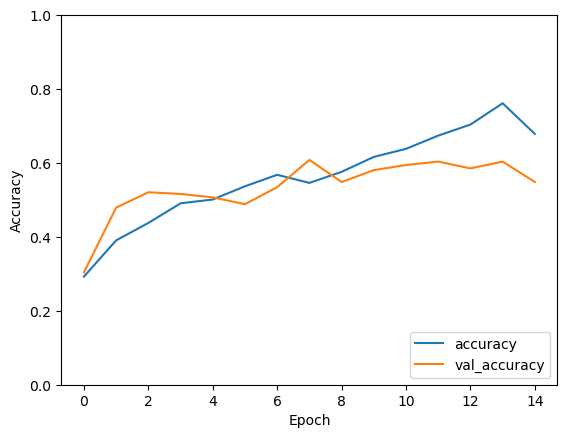

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

### Evaluating the model based on the testing images

In [21]:
test_loss, test_acc = model.evaluate(test_img,  test_lab, verbose=2)
print(test_acc)

7/7 - 3s - loss: 1.3756 - accuracy: 0.5484 - 3s/epoch - 406ms/step
0.5483871102333069


### Using the model to predict an image I found

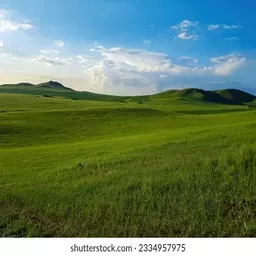

In [32]:
grass = Image.open("D:\Dataset Images\img_0623.webp")
grass_ary = np.array(grass) / 255
grass_inp = np.expand_dims(grass_ary, axis=0)
grass

In [33]:
model.predict(grass_inp)
# [desert, aquatic, tundra, forest, grassland]

1/1 [==============================] - 0s 121ms/step


array([[3.5570626e-08, 3.2283739e-07, 5.5751175e-06, 2.5303838e-05,
        9.9996877e-01]], dtype=float32)

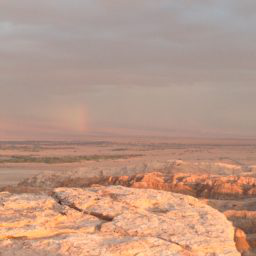

In [34]:
sand = Image.open("D:\Dataset Images\img_0001.jpg")
sand_ary = np.array(sand) / 255
sand_inp = np.expand_dims(sand_ary, axis=0)
sand

In [35]:
model.predict(sand_inp)
# [desert, aquatic, tundra, forest, grassland]

1/1 [==============================] - 0s 40ms/step


array([[9.9595547e-01, 1.5681102e-06, 1.4717155e-03, 1.2905334e-04,
        2.4422060e-03]], dtype=float32)

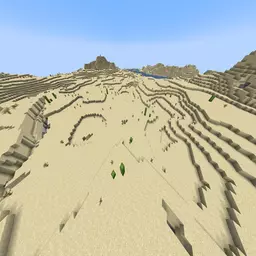

In [36]:
mc_sand = Image.open("D:\Dataset Images\desert.webp")
mc_sand_ary = np.array(mc_sand) / 255
mc_sand_inp = np.expand_dims(mc_sand_ary, axis=0)
mc_sand

In [37]:
model.predict(mc_sand_inp)
# [desert, aquatic, tundra, forest, grassland]

1/1 [==============================] - 0s 56ms/step


array([[9.7706044e-01, 6.0720217e-06, 3.4113440e-03, 4.6333726e-04,
        1.9058827e-02]], dtype=float32)

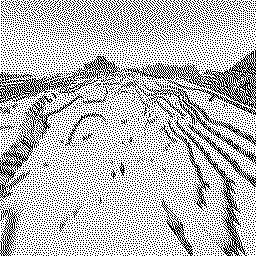

In [38]:
mc_sand = Image.open("D:\Dataset Images\desert.webp")
mc_sand_ary = np.array(mc_sand) / 255
mc_sand_inp = np.expand_dims(mc_sand_ary, axis=0)
sand_bw = mc_sand.convert("1")
sand_bw

In [39]:
model.predict(mc_sand_inp)
# [desert, aquatic, tundra, forest, grassland]

1/1 [==============================] - 0s 64ms/step


array([[9.7706044e-01, 6.0720217e-06, 3.4113440e-03, 4.6333726e-04,
        1.9058827e-02]], dtype=float32)

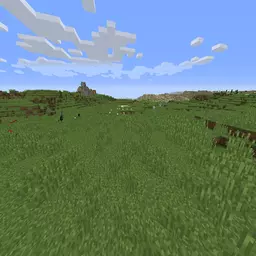

In [40]:
mc_plains = Image.open("D:\Dataset Images\plains.webp")
mc_plains_ary = np.array(mc_plains) / 255
mc_plains_inp = np.expand_dims(mc_plains_ary, axis=0)
mc_plains

In [41]:
model.predict(mc_plains_inp)
# [desert, aquatic, tundra, forest, grassland]

1/1 [==============================] - 0s 56ms/step


array([[2.4669589e-07, 6.7198010e-07, 2.7863003e-04, 7.0746796e-06,
        9.9971336e-01]], dtype=float32)

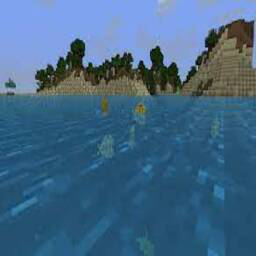

In [42]:
mc_ocean = Image.open("D:\Dataset Images\ocean.jpg")
mc_ocean_ary = np.array(mc_ocean) / 255
mc_ocean_inp = np.expand_dims(mc_ocean_ary, axis=0)
mc_ocean

In [43]:
model.predict(mc_ocean_inp)
# [desert, aquatic, tundra, forest, grassland]

1/1 [==============================] - 0s 56ms/step


array([[3.4092620e-04, 1.5501342e-05, 5.3905945e-02, 9.4573158e-01,
        6.1077285e-06]], dtype=float32)

In [44]:
# INCORRECT

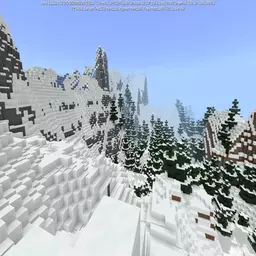

In [45]:
mc_tundra = Image.open("D:\Dataset Images\\tundra.webp")
mc_tundra_ary = np.array(mc_tundra) / 255
mc_tundra_inp = np.expand_dims(mc_tundra_ary, axis=0)
mc_tundra

In [46]:
model.predict(mc_tundra_inp)
# [desert, aquatic, tundra, forest, grassland]

1/1 [==============================] - 0s 57ms/step


array([[1.8708738e-06, 6.0570687e-07, 9.9915731e-01, 7.9535111e-04,
        4.4863391e-05]], dtype=float32)

### Tensorboard for Hyperparameter Tuning

In [24]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
HP_L2 = hp.HParam('regularizer', hp.RealInterval(0.001, 0.1))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'val_accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_L2, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Validation Accuracy')],
  )

In [30]:
def train_test_model(hparams):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(hparams[HP_L2])),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(5, activation="softmax")
    ])
    model.compile(optimizer=hparams[HP_OPTIMIZER],
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10)
    _, accuracy = model.evaluate(x_test, y_test, callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
    ])
    return accuracy

In [27]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1


In [ ]:
%tensorboard --logdir logs/hparam_tuning